In [49]:
import itertools
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [50]:
# For reproducibility
test_seed = 42
random.seed(test_seed)
np.random.seed(test_seed)

# Generate 10 random city coordinates within a 100x100 grid
NUM_CITIES = 10
cities = {f"C{i}": (random.uniform(0, 100), random.uniform(0, 100)) for i in range(NUM_CITIES)}

# Distance function
def distance(p, q):
    return math.hypot(p[0] - q[0], p[1] - q[1])

# Precompute distance matrix
distances = {u: {v: distance(cities[u], cities[v]) for v in cities} for u in cities}

def tour_length(path):
    return sum(distances[path[i]][path[(i+1) % len(path)]] for i in range(len(path)))

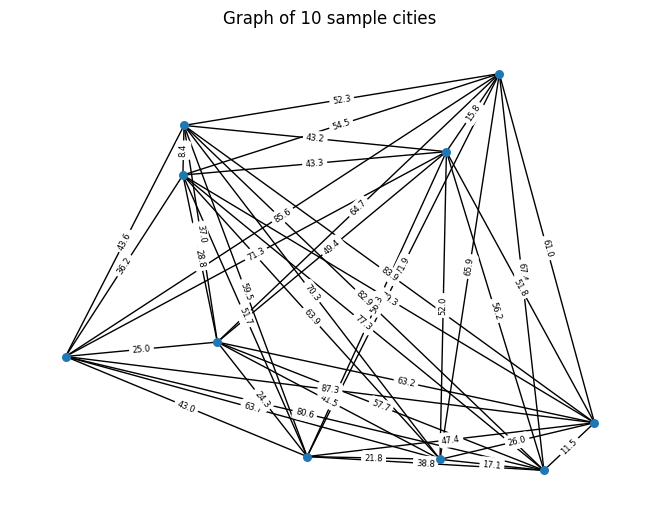

In [51]:
G = nx.Graph()
G.add_nodes_from(cities)
for u,v in itertools.combinations(cities,2):
    G.add_edge(u,v, weight=round(distances[u][v],1))
pos = {c: cities[c] for c in cities}

nx.draw(G, pos, with_labels=False, node_size=30)
edgelabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgelabels,font_size=6)
plt.title('Graph of 10 sample cities')
plt.axis('off'); plt.show()

In [52]:
start = time.time()
best_length = float('inf')
best_path = None
for perm in itertools.permutations(cities):
    length = sum(distances[perm[i]][perm[(i+1)%len(cities)]] for i in range(len(cities)))
    if length < best_length:
        best_length = length
        best_path = perm
brute_time = time.time() - start
print(f"Brute Force → Length: {best_length:.2f}, Time: {brute_time:.4f}s")

Brute Force → Length: 264.14, Time: 4.4162s


In [53]:
best_path

('C0', 'C4', 'C1', 'C6', 'C5', 'C8', 'C2', 'C7', 'C3', 'C9')

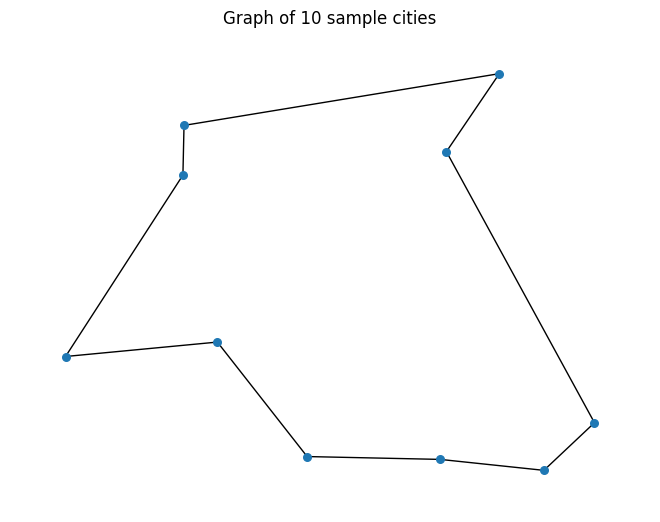

In [54]:
new_G = nx.Graph()

for a, b in zip(best_path, best_path[1:] + best_path[:1]):
    new_G.add_edge(a, b, weight=G[a][b].get('weight'))


nx.draw(new_G, pos, with_labels=False, node_size=30)
edgelabels = nx.get_edge_attributes(G,'weight')
plt.title('Graph of 10 sample cities')
plt.axis('off'); plt.show()

# Nearest Neighbor

In [55]:

def nearest_neighbor(G : nx.Graph) -> tuple[list[str], float]:
    n = NUM_CITIES
    first = list(G.nodes)[0]

    #initialize route at the first node
    route = [first] 
    visited = {first}
    best_distance = 0
    while len(visited) < n: 
        current_node = route[-1]
        #Finds the nearest node to the current node that has not been visited yet
        nearest_node, distance = min([(i, G[current_node][i].get('weight')) for i in G[current_node] if i not in visited], key=lambda x: x[1])

        route.append(nearest_node)
        visited.add(nearest_node)
        best_distance += distance
    else:
        #Connect last node distance to the first node distance
        best_distance += G[current_node][first].get('weight')
    return (route, best_distance)

start = time.time()
nn_path, nn_length = nearest_neighbor(G)
nn_time = time.time() - start
print(f"Nearest Neighbor Time: {(nn_time * 1000):.4f}ms | Best Distance: {nn_length} Path: {nn_path}")

Nearest Neighbor Time: 0.0978ms | Best Distance: 280.90000000000003 Path: ['C0', 'C9', 'C3', 'C4', 'C1', 'C6', 'C5', 'C8', 'C7', 'C2']


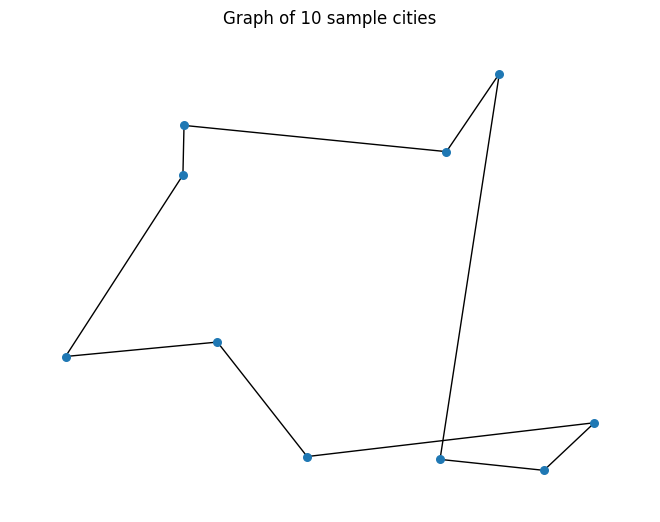

In [56]:
new_G = nx.Graph()

for a, b in zip(nn_path, nn_path[1:] + nn_path[:1]):
    new_G.add_edge(a, b, weight=G[a][b].get('weight'))

nx.draw(new_G, pos, with_labels=False, node_size=30)
edgelabels = nx.get_edge_attributes(G,'weight')
plt.title('Graph of 10 sample cities')
plt.axis('off'); plt.show()

## Genetic Algorithm

In [57]:
import networkx as nx
import random 
from functools import cache

def random_population(nodes: list, size: int):
    return [tuple(random.sample(nodes, len(nodes))) for _ in range(size)]

def genetic_alg(G: nx.Graph, pop_size: int, mutation_rate: float, generations: int) -> tuple[list, float]:
    # Initialize a random population
    nodes = list(G.nodes)
    def crossover(parent1: list, parent2: list):
        size = len(nodes)
        start, end = sorted(random.sample(range(size), 2))
        
        child  = [None] * size
        # Step 1: Copy a slice from parent1
        child[start:end] = parent1[start:end]

        # Step 2: Fill remaining from parent2
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while parent2[p2_idx] in child:
                    p2_idx += 1
                child[i] = parent2[p2_idx]
        return tuple(child)
    
    def mutate(route : tuple):
        route = list(route)[:]
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(nodes)), 2)
            route[i], route[j] = route[j], route[i]
        return tuple(route)
    
    def get_parent(population: list[tuple]) -> list:
        candidates = random.sample(population, 3)
        candidates.sort(key=lambda x : fitness(x), reverse=True)
        return candidates[0]

    @cache
    def get_length(tour: tuple) -> float:
        return tour_length(tour)

    @cache
    def fitness(tour : tuple) -> float:
        return 1 / get_length(tour)

    population = random_population(nodes, pop_size)

    best_distance = float('Inf')
    best_tour: tuple = None

    for gen in range(generations):
        new_population: list[list] = []
        for _ in range(pop_size):
            p1 = get_parent(population)
            p2 = get_parent(population)
            while p1 == p2:
                p2 = get_parent(population)
            child = crossover(p1, p2)
            child = mutate(child)
            new_population.append(child)
        population = new_population
        current_best_tour = min(population, key=lambda r: fitness(r))
        current_best_distance = get_length(current_best_tour)
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_tour = current_best_tour
    
    return best_tour, best_distance



POP_SIZE = 100
GENERATIONS = 500
MUTATION_RATE = 0.01
start = time.time()
route, ga_length = genetic_alg(G, POP_SIZE, MUTATION_RATE, GENERATIONS)
ga_time = time.time() - start


In [58]:
import networkx as nx
import random 
from functools import cache
import numpy as np


def simulated_annealing(G: nx.Graph, temperature: float, alpha: float, iterations: int) -> tuple[tuple, float]:

    nodes = list(G.nodes)
    distances = {u: {v: G[u][v]['weight'] for v in G[u] if u != v} for u in nodes}
    @cache
    def get_length(tour: tuple) -> float:
        tour_size = len(tour)
        return sum(
            distances[tour[i]][tour[(i+1) % tour_size]] for i in range(tour_size)
        ) 
    
    def random_neighbor(tour: tuple) -> tuple:
        neighbor = list(tour)
        i, j = random.sample(range(len(tour)), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        return tuple(neighbor)

    current_tour = tuple(random.sample(nodes, len(nodes)))
    current_distance = get_length(current_tour)
    best_tour = current_tour
    best_distance = current_distance

    for _ in range(iterations):
        next_tour =  random_neighbor(current_tour)
        next_distance = get_length(next_tour)

        if next_distance < current_distance or random.random() < np.exp((current_distance - next_distance) / temperature):
            current_tour, current_distance = next_tour, next_distance

            if current_distance < best_distance:
                best_tour, best_distance = current_tour, current_distance

        temperature *= alpha

    return best_tour, best_distance



T, ALPHA, ITER = 10000, 0.995, 20000
start = time.time()
route, best_e = simulated_annealing(G, T, ALPHA, ITER)
sa_time = time.time() - start
print(f"Simulated Annealing Time: {(sa_time * 1000):.4f}ms | Best Distance: {best_e} Path: {route}")

Simulated Annealing Time: 52.8486ms | Best Distance: 264.2 Path: ('C9', 'C3', 'C7', 'C2', 'C8', 'C5', 'C6', 'C1', 'C4', 'C0')


Algorithm            |   Distance |  Time(s)
---------------------------------------------
Brute Force          |     264.14 |   4.4162
Nearest Neighbor     |     280.90 |   0.0001
Genetic Algorithm    |     264.16 |   1.3667
Simulated Annealing  |     264.20 |   0.0528


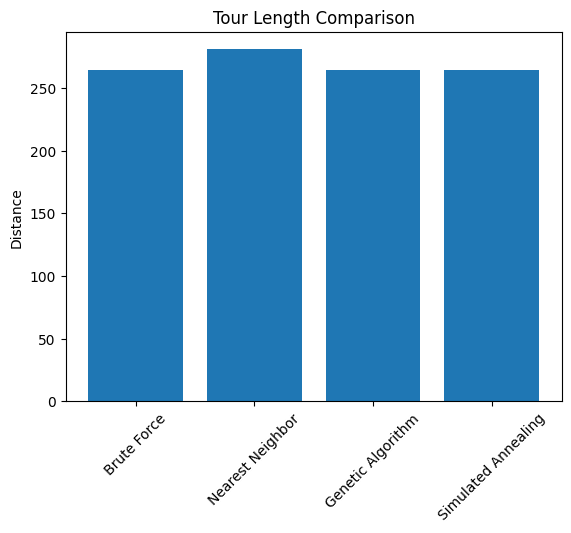

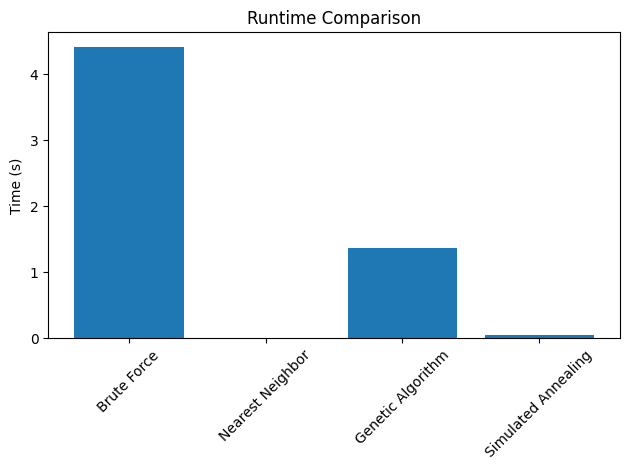

In [59]:
results = [
    ('Brute Force', best_length, brute_time),
    ('Nearest Neighbor', nn_length, nn_time),
    ('Genetic Algorithm', ga_length, ga_time),
    ('Simulated Annealing', best_e, sa_time),
    # ('Ant Colony', best_len, aco_time)
]

# Table
print(f"{'Algorithm':20s} | {'Distance':>10s} | {'Time(s)':>8s}")
print('-'*45)
for name, dist, t in results:
    print(f"{name:20s} | {dist:10.2f} | {t:8.4f}")

# Charts
labels = [r[0] for r in results]
distances_cmp = [r[1] for r in results]
times_cmp = [r[2] for r in results]

plt.figure()
plt.bar(labels, distances_cmp)
plt.title('Tour Length Comparison')
plt.ylabel('Distance')
plt.xticks(rotation=45)

plt.figure()
plt.bar(labels, times_cmp)
plt.title('Runtime Comparison')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()